In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

In [2]:
DATA_DIR = "/media/dtsarev/SatSSD/data/audio"
TRAIN_CSV = "/media/dtsarev/SatSSD/data/train_split.csv"
VAL_CSV = "/media/dtsarev/SatSSD/data/valid_split.csv"
EMBED_DIR = "./embeddings_wav2vec"
MODEL_NAME = "facebook/wav2vec2-base"
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIM = 6  # number of emotions
BEST_MODEL_PATH = "best_model.pth"
MAX_SEQ_LEN = 1000  # maximum sequence length for embeddings
MAX_AUDIO_LEN_SEC = 12  # maximum audio length (seconds)

os.makedirs(EMBED_DIR, exist_ok=True)

In [3]:
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
wav2vec = Wav2Vec2Model.from_pretrained(MODEL_NAME).to(DEVICE)
wav2vec.eval()

/home/dtsarev/master_of_cv/DIPLOM/repos/venv/lib/python3.11/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [4]:
def extract_and_save_embeddings(csv_file, split_name):
    df = pd.read_csv(csv_file, dtype={'Filename': str})
    df['Filename'] = df['Filename'].str.zfill(5)
    for _, row in df.iterrows():
        fname = row['Filename']
        mp3_path = os.path.join(DATA_DIR, f"{fname}.mp3")
        emb_path = os.path.join(EMBED_DIR, f"{split_name}_{fname}.pt")
        if os.path.exists(emb_path):
            continue
        try:
            waveform, sr = torchaudio.load(mp3_path)
            # skip empty files
            if waveform.numel() == 0:
                raise ValueError("Empty file")
            # truncate to MAX_AUDIO_LEN_SEC seconds
            max_samples = sr * MAX_AUDIO_LEN_SEC
            if waveform.size(1) > max_samples:
                waveform = waveform[:, :max_samples]
            # normalize waveform (zero mean, unit std)
            waveform = waveform - waveform.mean()
            std = waveform.std()
            if std > 0:
                waveform = waveform / std
            else:
                waveform = waveform / (waveform.abs().max() + 1e-8)
            # extract embeddings
            inputs = processor(waveform.squeeze().numpy(), sampling_rate=sr, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(DEVICE)
            with torch.no_grad():
                outputs = wav2vec(input_values)
            hidden_states = outputs.last_hidden_state.squeeze(0).cpu()
            torch.save(hidden_states, emb_path)
        except Exception as e:
            print(f"Failed to process {mp3_path}: {e}")

In [5]:
extract_and_save_embeddings(TRAIN_CSV, "train")
extract_and_save_embeddings(VAL_CSV, "val")

In [6]:
class AudioEmotionDataset(Dataset):
    def __init__(self, csv_file, split_name):
        df = pd.read_csv(csv_file, dtype={'Filename': str})
        df['Filename'] = df['Filename'].str.zfill(5)
        valid = df['Filename'].apply(
            lambda f: os.path.exists(os.path.join(EMBED_DIR, f"{split_name}_{f}.pt"))
        )
        if (~valid).any():
            print(f"Warning: { (~valid).sum() } missing embeddings in {split_name}")
        self.df = df[valid].reset_index(drop=True)
        self.split = split_name
        self.labels = ['Admiration','Amusement','Determination','Empathic Pain','Excitement','Joy']
        self.emotions = self.df[self.labels].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.iloc[idx]['Filename']
        emb = torch.load(os.path.join(EMBED_DIR, f"{self.split}_{fname}.pt"))
        return emb, torch.tensor(self.emotions[idx])

In [7]:
# Pad sequences in batch
def collate_fn(batch):
    seqs, labels = zip(*batch)
    seqs = [s[:MAX_SEQ_LEN] if s.size(0)>MAX_SEQ_LEN else s for s in seqs]
    padded = pad_sequence(seqs, batch_first=True)
    means = torch.stack([s.mean(dim=0) for s in seqs])
    labels = torch.stack(labels)
    return padded, means, labels

In [8]:
train_dataset = AudioEmotionDataset(TRAIN_CSV, "train")
val_dataset = AudioEmotionDataset(VAL_CSV, "val")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [9]:
class FusionClassifier(nn.Module):
    def __init__(self, hidden_size, fusion_dim=512, lstm_hidden=256, num_heads=8, num_layers=2, dropout=0.2):
        super().__init__()
        # Fusion projection for per-step + global mean
        self.step_proj = nn.Linear(hidden_size * 2, fusion_dim)
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=fusion_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # BiLSTM for temporal modeling
        self.lstm = nn.LSTM(fusion_dim, lstm_hidden, batch_first=True, bidirectional=True)
        # Attention pooling over LSTM outputs
        self.attn = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 1),
            nn.Softmax(dim=1)
        )
        # Final regression head
        self.regressor = nn.Sequential(
            nn.Linear(lstm_hidden * 2, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, OUTPUT_DIM)
        )

    def forward(self, seq, global_mean):
        # seq: (batch, seq_len, hidden), global_mean: (batch, hidden)
        # expand global_mean to seq_len
        gm = global_mean.unsqueeze(1).expand(-1, seq.size(1), -1)  # (batch, seq_len, hidden)
        # concatenate
        x = torch.cat([seq, gm], dim=-1)  # (batch, seq_len, hidden*2)
        x = self.step_proj(x)  # (batch, seq_len, fusion_dim)
        # transformer
        x = self.transformer(x)
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_hidden*2)
        # attention pooling
        weights = self.attn(lstm_out).squeeze(-1)  # (batch, seq_len)
        pooled = torch.bmm(weights.unsqueeze(1), lstm_out).squeeze(1)  # (batch, lstm_hidden*2)
        # regression
        return self.regressor(pooled)

In [10]:
model = FusionClassifier(
    hidden_size=wav2vec.config.hidden_size,
    fusion_dim=512,
    lstm_hidden=256,
    num_heads=8,
    num_layers=2,
    dropout=0.2
).to(DEVICE)

In [10]:
class AttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        # Project input embeddings to model dimension
        self.proj = nn.Linear(input_dim, hidden_dim)
        # Positional encoding helper (optional for single-token input, can skip)
        # Define Transformer Encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Attention pooling: compute attention weights over sequence dimension
        self.attn_pool = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        # x: (batch, input_dim)
        h = self.proj(x)  # (batch, hidden_dim)
        # Add sequence dimension (seq_len=1) and repeat if variable length already pooled
        # Here, we treat projected embedding as single time-step
        h = h.unsqueeze(1)  # (batch, 1, hidden_dim)
        # Pass through transformer encoder
        enc = self.transformer(h)  # (batch, 1, hidden_dim)
        # Attention pooling across sequence (though seq_len=1, still applies)
        attn_weights = self.attn_pool(enc).squeeze(-1)  # (batch, seq_len)
        pooled = torch.bmm(attn_weights.unsqueeze(1), enc).squeeze(1)  # (batch, hidden_dim)
        # Classification
        return self.classifier(pooled)

In [11]:
input_dim = wav2vec.config.hidden_size
model = AttentionClassifier(
    input_dim=input_dim,
    hidden_dim=512,
    output_dim=OUTPUT_DIM,
    n_heads=8,
    num_layers=2,
    dropout=0.2
).to(DEVICE)

In [11]:
def pearson_corr(preds, targets):
    preds = preds.detach().cpu()
    targets = targets.detach().cpu()
    vx = preds - preds.mean(0)
    vy = targets - targets.mean(0)
    corr = (vx * vy).sum(0) / (torch.sqrt((vx ** 2).sum(0) * (vy ** 2).sum(0)) + 1e-8)
    return corr.mean().item()

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [13]:
def train_epoch(model, loader):
    model.train()
    running_loss = 0.0
    running_corr = 0.0
    for seqs, global_means, labels in tqdm(loader, desc="Training"):
        seqs = seqs.to(DEVICE)
        global_means = global_means.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        preds = model(seqs, global_means)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corr += pearson_corr(preds, labels)
    return running_loss / len(loader), running_corr / len(loader)

def validate_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    running_corr = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for seqs, global_means, labels in tqdm(loader, desc="Validation"):
            seqs = seqs.to(DEVICE)
            global_means = global_means.to(DEVICE)
            labels = labels.to(DEVICE)
            preds = model(seqs, global_means)
            running_loss += criterion(preds, labels).item()
            running_corr += pearson_corr(preds, labels)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return running_loss / len(loader), running_corr / len(loader), all_preds, all_labels

In [14]:
train_losses, val_losses = [], []
train_corrs, val_corrs = [], []
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    t_loss, t_corr = train_epoch(model, train_loader)
    v_loss, v_corr, val_preds, val_labels = validate_epoch(model, val_loader)

    train_losses.append(t_loss); val_losses.append(v_loss)
    train_corrs.append(t_corr); val_corrs.append(v_corr)

    print(f"Epoch {epoch} | Train Loss: {t_loss:.4f}, Train Corr: {t_corr:.4f} | "
          f"Val Loss: {v_loss:.4f}, Val Corr: {v_corr:.4f}")

    # Scheduler step on validation loss
    scheduler.step(v_loss)

    # Check improvement for early stopping
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        epochs_no_improve = 0
        print("-> New best model saved.")
    else:
        epochs_no_improve += 1
        #if epochs_no_improve >= 5:
        #    print("Stopping early: no improvement in validation loss for 5 epochs.")
        #    break

Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.87it/s]


Epoch 1 | Train Loss: 0.0429, Train Corr: 0.0265 | Val Loss: 0.0387, Val Corr: 0.0499
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.85it/s]


Epoch 2 | Train Loss: 0.0419, Train Corr: 0.0698 | Val Loss: 0.0384, Val Corr: 0.0581
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 38.01it/s]


Epoch 3 | Train Loss: 0.0416, Train Corr: 0.0985 | Val Loss: 0.0385, Val Corr: 0.0723


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.86it/s]


Epoch 4 | Train Loss: 0.0413, Train Corr: 0.1300 | Val Loss: 0.0382, Val Corr: 0.0781
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.68it/s]


Epoch 5 | Train Loss: 0.0410, Train Corr: 0.1442 | Val Loss: 0.0382, Val Corr: 0.0817
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.55it/s]


Epoch 6 | Train Loss: 0.0405, Train Corr: 0.1677 | Val Loss: 0.0393, Val Corr: 0.0889


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.57it/s]


Epoch 7 | Train Loss: 0.0403, Train Corr: 0.1786 | Val Loss: 0.0381, Val Corr: 0.0997
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 36.92it/s]


Epoch 8 | Train Loss: 0.0401, Train Corr: 0.1966 | Val Loss: 0.0385, Val Corr: 0.0965


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.80it/s]


Epoch 9 | Train Loss: 0.0395, Train Corr: 0.2198 | Val Loss: 0.0382, Val Corr: 0.0915


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.79it/s]


Epoch 10 | Train Loss: 0.0392, Train Corr: 0.2248 | Val Loss: 0.0380, Val Corr: 0.1013
-> New best model saved.


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.22it/s]


Epoch 11 | Train Loss: 0.0388, Train Corr: 0.2416 | Val Loss: 0.0389, Val Corr: 0.1005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.77it/s]


Epoch 12 | Train Loss: 0.0384, Train Corr: 0.2609 | Val Loss: 0.0384, Val Corr: 0.1035


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.46it/s]


Epoch 13 | Train Loss: 0.0379, Train Corr: 0.2746 | Val Loss: 0.0393, Val Corr: 0.1053


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.74it/s]


Epoch 14 | Train Loss: 0.0374, Train Corr: 0.2936 | Val Loss: 0.0394, Val Corr: 0.1052


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.88it/s]


Epoch 15 | Train Loss: 0.0363, Train Corr: 0.3182 | Val Loss: 0.0388, Val Corr: 0.1057


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.88it/s]


Epoch 16 | Train Loss: 0.0359, Train Corr: 0.3328 | Val Loss: 0.0392, Val Corr: 0.1029


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.70it/s]


Epoch 17 | Train Loss: 0.0355, Train Corr: 0.3479 | Val Loss: 0.0393, Val Corr: 0.1025


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.82it/s]


Epoch 18 | Train Loss: 0.0351, Train Corr: 0.3594 | Val Loss: 0.0392, Val Corr: 0.1045


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.69it/s]


Epoch 19 | Train Loss: 0.0344, Train Corr: 0.3743 | Val Loss: 0.0396, Val Corr: 0.1073


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.73it/s]


Epoch 20 | Train Loss: 0.0341, Train Corr: 0.3837 | Val Loss: 0.0393, Val Corr: 0.1090


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.73it/s]


Epoch 21 | Train Loss: 0.0339, Train Corr: 0.3902 | Val Loss: 0.0393, Val Corr: 0.1058


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.52it/s]


Epoch 22 | Train Loss: 0.0336, Train Corr: 0.3936 | Val Loss: 0.0395, Val Corr: 0.1048


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.96it/s]


Epoch 23 | Train Loss: 0.0332, Train Corr: 0.4085 | Val Loss: 0.0396, Val Corr: 0.1066


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.65it/s]


Epoch 24 | Train Loss: 0.0330, Train Corr: 0.4056 | Val Loss: 0.0398, Val Corr: 0.1054


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.66it/s]


Epoch 25 | Train Loss: 0.0328, Train Corr: 0.4138 | Val Loss: 0.0398, Val Corr: 0.1059


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.46it/s]


Epoch 26 | Train Loss: 0.0327, Train Corr: 0.4144 | Val Loss: 0.0398, Val Corr: 0.1058


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 37.63it/s]


Epoch 27 | Train Loss: 0.0325, Train Corr: 0.4148 | Val Loss: 0.0398, Val Corr: 0.1065


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 38.15it/s]


Epoch 28 | Train Loss: 0.0324, Train Corr: 0.4255 | Val Loss: 0.0399, Val Corr: 0.1052


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 38.19it/s]


Epoch 29 | Train Loss: 0.0323, Train Corr: 0.4239 | Val Loss: 0.0400, Val Corr: 0.1062


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 38.24it/s]


Epoch 30 | Train Loss: 0.0322, Train Corr: 0.4286 | Val Loss: 0.0399, Val Corr: 0.1055


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 38.08it/s]


Epoch 31 | Train Loss: 0.0321, Train Corr: 0.4295 | Val Loss: 0.0400, Val Corr: 0.1054


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 36.93it/s]


Epoch 32 | Train Loss: 0.0321, Train Corr: 0.4245 | Val Loss: 0.0399, Val Corr: 0.1061


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:07<00:00, 36.54it/s]


Epoch 33 | Train Loss: 0.0321, Train Corr: 0.4270 | Val Loss: 0.0400, Val Corr: 0.1059


Training:  12%|█████████████▏                                                                                                   | 59/505 [00:04<00:31, 14.04it/s]


KeyboardInterrupt: 

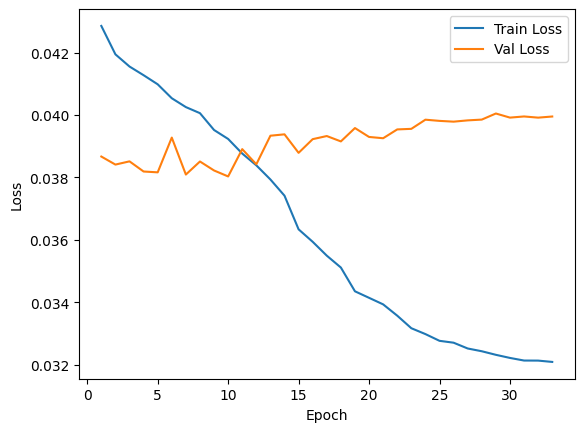

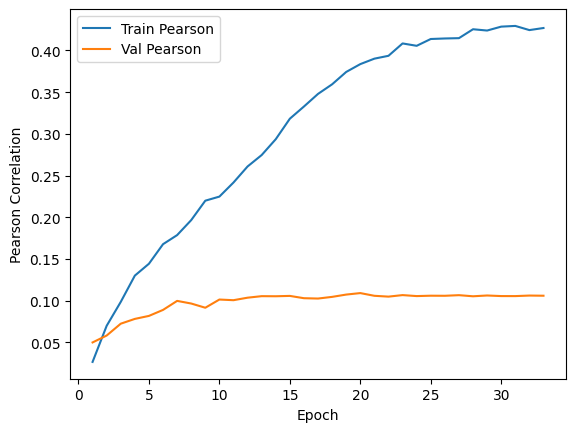

In [15]:
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(range(1, len(train_corrs)+1), train_corrs, label='Train Pearson')
plt.plot(range(1, len(val_corrs)+1), val_corrs, label='Val Pearson')
plt.xlabel('Epoch'); plt.ylabel('Pearson Correlation'); plt.legend(); plt.show()

In [15]:
labels = ['Admiration', 'Amusement', 'Determination', 'Empathic Pain', 'Excitement', 'Joy']
per_emotion_corr = {}
for i, emo in enumerate(labels):
    px = val_preds[:, i] - val_preds[:, i].mean()
    ty = val_labels[:, i] - val_labels[:, i].mean()
    per_emotion_corr[emo] = ((px * ty).sum() / (torch.sqrt((px**2).sum() * (ty**2).sum()) + 1e-8)).item()
print("Per-emotion Pearson correlation on validation set:")
for emo, corr in per_emotion_corr.items():
    print(f"{emo}: {corr:.4f}")

Per-emotion Pearson correlation on validation set:
Admiration: 0.1016
Amusement: 0.1357
Determination: 0.1346
Empathic Pain: 0.0564
Excitement: 0.1675
Joy: 0.1209
